In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_str = "17"
session.query(Measurement.date).\
   filter(func.strftime("%m", Measurement.date) == date_str).all()

# Calculate the date 1 year ago from the last data point in the database

#session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=362)
print("Query Date: ", query_date)

# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(['date', 'prcp']) 
measurement_df.set_index('date')
measurement_df.head()

# Sort the dataframe by date
measurement_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
#measurement_df.plot(kind="bar", figsize=(10,10))
#plt.tight_layout()
#plt.show()

Query Date:  2016-08-26


KeyError: 'date'

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


![describe](Images/describe.png)

In [55]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()


9

In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, func.min(tobs), func.max(tobs), func.avg(tobs)).\
    filter(Measurement.station == '2772')

NameError: name 'tobs' is not defined

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


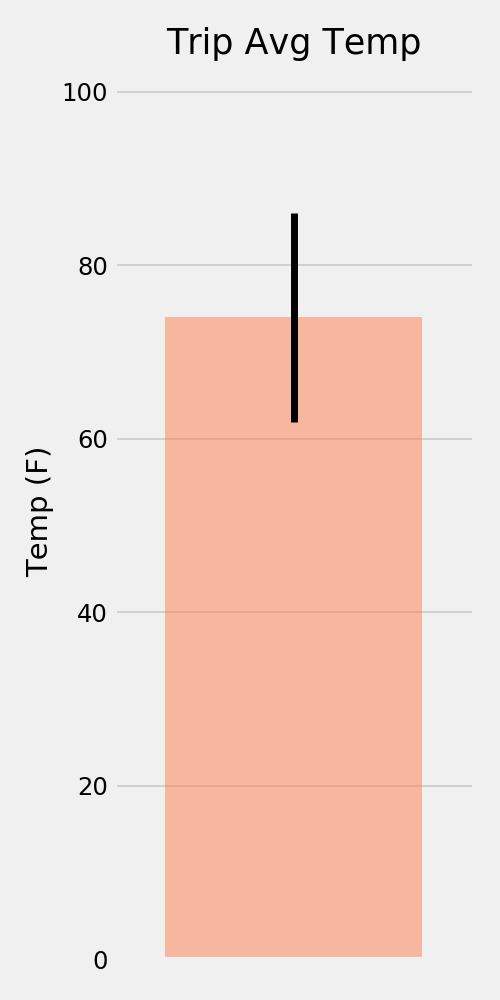

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [10]:
# Plot the daily normals as an area plot with `stacked=False`
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
date_prcp = session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date).all()
date_prcp

[('2010-01-01', 0.14),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-06', 0.36),
 ('2010-01-07', 0.3),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.01),
 ('2010-01-11', 0.14),
 ('2010-01-12', 0.0),
 ('2010-01-13', 0.0),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0),
 ('2010-01-16', 0.0),
 ('2010-01-17', 0.0),
 ('2010-01-18', 0.0),
 ('2010-01-19', 0.0),
 ('2010-01-20', 0.0),
 ('2010-01-21', 0.32),
 ('2010-01-22', 0.0),
 ('2010-01-23', 0.0),
 ('2010-01-24', 0.01),
 ('2010-01-25', 0.0),
 ('2010-01-26', 0.03),
 ('2010-01-27', 0.31),
 ('2010-01-28', 0.07),
 ('2010-01-29', 0.1),
 ('2010-01-30', 0.33),
 ('2010-01-31', 1.1),
 ('2010-02-01', 0.01),
 ('2010-02-02', 0.05),
 ('2010-02-03', 0.67),
 ('2010-02-04', 0.0),
 ('2010-02-05', 0.09),
 ('2010-02-06', 0.04),
 ('2010-02-07', 0.0),
 ('2010-02-08', 0.0),
 ('2010-02-09', 0.0),
 ('2010-02-10', 0.0),
 ('2010-02-11', 0.0),
 ('2010-02-12', 0.65),
 ('2010-02-13', 0.62),
 ('2010-02-14',

In [36]:
measurement_df = pd.DataFrame(date_prcp)
measurement_df.set_index('date')

measurement_df.head()

,date,prcp
0,2010-01-01,0.14
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-05,0.00


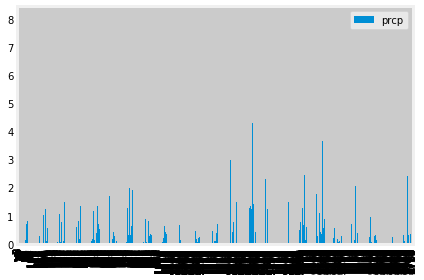

In [39]:
df = pd.DataFrame(measurement_df)
df.plot.bar()
plt.tight_layout()
plt.show()

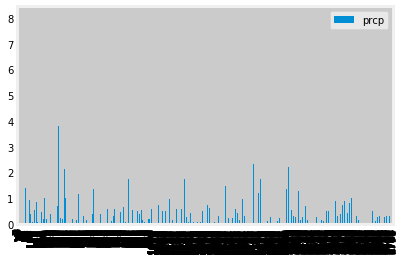

In [38]:
measurement_df.plot(kind="bar")
#plt.tight_layout()
plt.show()


In [37]:
measurement_df.sort_values(by=['date'])

,date,prcp
0,2010-01-01,0.14
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-05,0.00
5,2010-01-06,0.36
6,2010-01-07,0.30
7,2010-01-08,0.00
8,2010-01-09,0.00
9,2010-01-10,0.01
